Este proyecto se haraán predicciones del valor del dolar en México. Para ésto se hace uso de la base de datos tomada de https://www.banxico.org.mxSieInternet/consultarDirectorioInternetAction.do?sector=6accion=consultarCuadroidCuadro=CF373&locale=es, de donde se toma la serie de tiempo a partir de la devaluación del peso (año 1994) hasta la actualidad.


Como primer paso, se cargan todas las paqueterías necesarias.

In [2]:
from tensorflow.keras import Sequential

In [49]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import plotly.graph_objects as go

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Para poder llevar a cabo la comparación entre los datos originales y los datos prnosticados, se hizo una separación de la base de datos en dos partes. Debido a que se hará un el pronóstico de los años 2024 y parte del 2025, se creo un archivo .csv que contiene los ya mencionados y que se usarán más adelante.

In [26]:
#Cargar los datos de entrenamiento
train_data=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Diplomado_Análisis de datos /Consulta_20250416-223426180.csv', index_col='Fecha', parse_dates=True)
train_data_or=train_data['Tipo de cambio ']

In [210]:
train_data.head()

,Tipo de cambio
Fecha,
03/01/1994,3.1075
04/01/1994,3.1129
05/01/1994,3.1060
06/01/1994,3.1057
07/01/1994,3.1057


In [27]:
imputer = SimpleImputer(strategy='mean')
train_data_or=pd.DataFrame(imputer.fit_transform(train_data), columns=train_data.columns, index=train_data.index)


In [28]:
# Escalado de datos
scaler = MinMaxScaler(feature_range=(0, 1))    ###transforma los datos en ceros y uno
train_scaled = scaler.fit_transform(train_data_or)

# Crear secuencias de temporales, datos para el entrenamiento
def create_dataset(dataset, look_back=60):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), :]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

X_train, y_train = create_dataset(train_scaled, 60)


In [29]:
train_scaled

array([[1.13566675e-04],
       [3.58870693e-04],
       [4.54266700e-05],
       ...,
       [7.72139823e-01],
       [7.68451178e-01],
       [7.66288868e-01]])

In [30]:
#Se crea el Modelo LSTM
model = Sequential([
    LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),  #return_sequences=True Devuelve salidas para cada paso (necesario para apilar LSTM)
    Dropout(0.2), #evita el sobreajuste , apaga aleatoriamete el 20% de las neuronas durante el entrenamiento#
    LSTM(100, return_sequences=False), #return sequences = False nos da la salid final y no toda la secuencia
    Dense(1) #capa final densa
])
model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [31]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 60, 100)        │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 60, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 121,301 (473.83 KB)

 Trainable params: 121,301 (473.83 KB)

 Non-trainable params: 0 (0.00 B)

In [32]:
# Entrenar el modelo
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)

Epoch 1/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 27s 95ms/step - loss: 0.0314
Epoch 2/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 22s 91ms/step - loss: 2.1331e-04
Epoch 3/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 42s 96ms/step - loss: 2.4202e-04
Epoch 4/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 40s 94ms/step - loss: 1.6292e-04
Epoch 5/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 41s 95ms/step - loss: 1.7589e-04
Epoch 6/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 41s 95ms/step - loss: 1.8781e-04
Epoch 7/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 43s 102ms/step - loss: 1.8895e-04
Epoch 8/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 39s 95ms/step - loss: 1.7861e-04
Epoch 9/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 22s 89ms/step - loss: 1.7623e-04
Epoch 10/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 41s 88ms/step - loss: 1.7929e-04
Epoch 11/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 44s 100ms/step - loss: 1.6154e-04
Epoch 12/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 38s 88ms/step - loss: 1.3121e-04
Epoch 13/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 42s 93ms/step - loss: 1.5687e-04
Epoch 14/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 41s 95ms

In [79]:
real_data_20245= pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Diplomado_Análisis de datos /Consulta_2025.csv', index_col='Fecha', parse_dates=True)
imputer = SimpleImputer(strategy='mean')
real_data_20245=real_data_20245['Tipo de cambio' ]
real_data_20245a = pd.DataFrame(imputer.fit_transform(real_data_20245.values.reshape(-1, 1)), columns=['Tipo de cambio'], index=real_data_20245.index)
real_scaled = scaler.transform(real_data_20245.values.reshape(-1, 1))


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



In [80]:
real_scaled

array([[0.63343857],
       [0.63328412],
       [0.62660186],
       [0.62272242],
       [0.62823722],
       [0.63080382],
       [0.63074023],
       [0.62475299],
       [0.62658369],
       [0.63846276],
       [0.64463625],
       [0.6402662 ],
       [0.63722261],
       [0.63631408],
       [0.64719377],
       [0.63880346],
       [0.64199241],
       [0.63873078],
       [0.64180162],
       [0.63998001],
       [0.63862175],
       [0.63726804],
       [0.63777682],
       [0.63282531],
       [0.63301156],
       [0.63585073],
       [0.63508756],
       [0.63429259],
       [0.64020715],
       [0.63622323],
       [0.63429259],
       [0.63393827],
       [0.63347491],
       [0.63328412],
       [0.63394281],
       [0.63670021],
       [0.63692734],
       [0.63692734],
       [0.63395189],
       [0.63557363],
       [0.63407909],
       [0.63218934],
       [0.63042224],
       [0.62782838],
       [0.62542531],
       [0.6256161 ],
       [0.62205011],
       [0.622

In [81]:
# Crear datos de entrada para predicción
X_real, _ = create_dataset(np.vstack([train_scaled[-70:], real_scaled]), 70)

# Predicciones
predictions_scaled = model.predict(X_real)
predictions = scaler.inverse_transform(np.concatenate([predictions_scaled, np.zeros((len(predictions_scaled), 2))], axis=1))[:, 0]

# Datos reales para comparar
real_valor = scaler.inverse_transform(real_scaled)[:, 0]

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step


In [82]:
predictions

array([20.22682921, 18.59898747, 17.96604812, 17.85159566, 17.54910255,
       17.52306248, 17.7310839 , 17.63242396, 17.43407802, 17.42733116,
       17.49955871, 17.53781318, 17.49836076, 17.42295922, 17.36771296,
       17.49991691, 17.44172366, 17.43208886, 17.4391703 , 17.46195635,
       17.44466541, 17.43504635, 17.41679757, 17.41538574, 17.35422713,
       17.33127707, 17.37967807, 17.38372723, 17.36384881, 17.45694279,
       17.43619838, 17.36908149, 17.36799507, 17.36184129, 17.3381735 ,
       17.35722267, 17.41028427, 17.42247637, 17.42541286, 17.39078768,
       17.39174683, 17.37865725, 17.34070324, 17.30654648, 17.26385315,
       17.21032444, 17.19822419, 17.14988879, 17.12827315, 17.14568743,
       17.07222125, 17.01724791, 17.02982577, 17.11886928, 17.08435168,
       17.06173227, 17.05735377, 17.01637799, 16.97907216, 16.88691896,
       16.9253427 , 16.90299096, 16.85190408, 16.83635824, 16.80765853,
       16.68905588, 16.6864684 , 16.77318161, 16.76196703, 16.88

In [83]:
# Asegurarse de que tanto 'real_demand' como 'predictions' tienen el mismo índice de tiempo
real_valor = pd.Series(real_valor[:len(predictions)], index=pd.to_datetime(real_data_20245.index[:len(predictions)], format='%d/%m/%Y'))
predictions_series = pd.Series(predictions, index=pd.to_datetime(real_data_20245.index[:len(predictions)], format='%d/%m/%Y'))

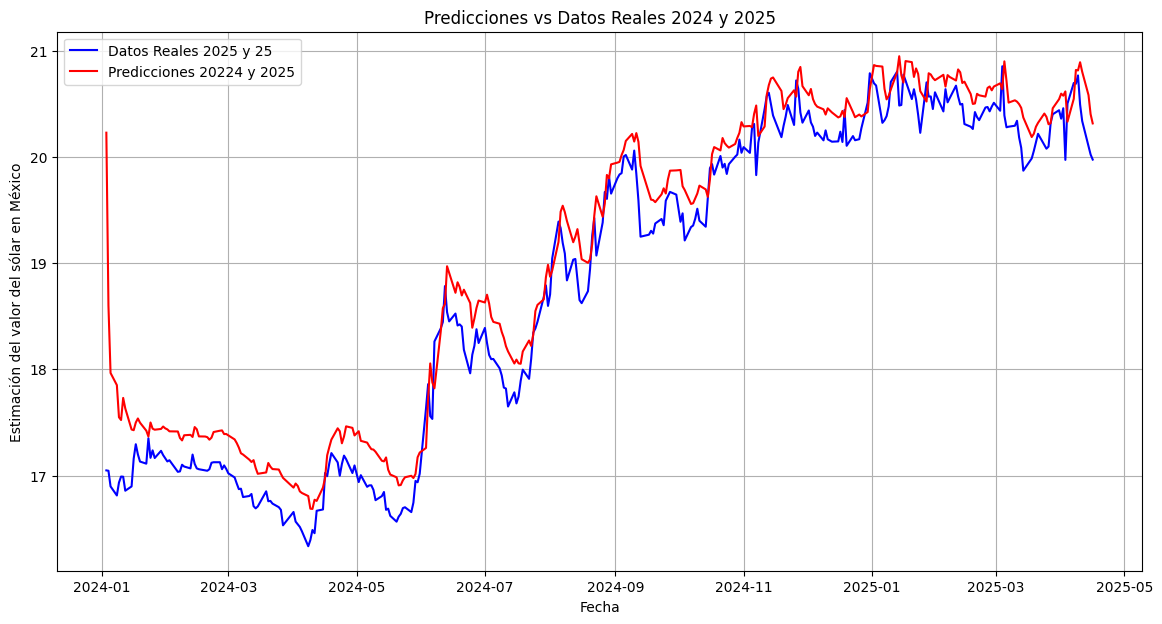

In [87]:
# Graficar
plt.figure(figsize=(14, 7))
plt.plot(real_data_20245.index, real_valor, label='Datos Reales 2025 y 25', color='blue')
plt.plot(real_data_20245.index[:len(predictions)], predictions, label='Predicciones 20224 y 2025', color='red')
plt.title('Predicciones vs Datos Reales 2024 y 2025')
plt.xlabel('Fecha')
plt.ylabel('Estimación del valor del sólar en México')
plt.legend()
plt.grid(True)
plt.show()

In [85]:
# Crear una lista para almacenar los R-squared de cada mes
r_squared_monthly = []

In [89]:
#Asegurarse de que tanto 'real_demand' como 'predictions' tienen el mismo índice de tiempo
# Convert 'real_data_2025.index' to DateTimeIndex
real_data_20245.index = pd.to_datetime(real_data_20245.index, format='%d/%m/%Y')
real_valor = pd.Series(real_valor[:len(predictions)], index=real_data_20245.index[:len(predictions)])
predictions_series = pd.Series(predictions, index=real_data_20245.index[:len(predictions)])

# Crear una lista para almacenar los R-squared de cada mes
r_squared_monthly = []

# Agrupar los datos por mes y calcular el R-squared para cada mes
for month, group in real_valor.groupby(real_valor.index.to_series().dt.month): # Convert index to series and extract month
    # Extraer las predicciones correspondientes para ese mes
    pred_for_month = predictions_series[group.index]

    # Eliminar los NaN de 'group' y 'pred_for_month' antes de calcular R-squared
    group = group.dropna()
    pred_for_month = pred_for_month[group.index]  # Asegurar que los índices coincidan después de eliminar NaN

    # Calcular el R-squared solo si hay datos válidos
    if len(group) > 0 and len(pred_for_month) > 0:
        r_squared = r2_score(group, pred_for_month)
        r_squared_monthly.append((month, r_squared))
        print(f'R-squared para el mes {month}: {r_squared}')
    else:
        print(f'No hay suficientes datos válidos para el mes {month} para calcular R-squared.')
    # Crear la figura usando Plotly para una mejor interactividad y presentación
fig = go.Figure()

# Añadir los datos reales a la gráfica
fig.add_trace(go.Scatter(x=real_data_20245.index, y=real_valor, mode='lines', name='Datos Reales 2024 y 2025', line=dict(color='blue')))

# Añadir las predicciones a la gráfica
fig.add_trace(go.Scatter(x=real_data_20245.index[:len(predictions)], y=predictions, mode='lines', name='Predicciones 2024 y 2025', line=dict(color='red')))

# Configuración adicional del gráfico
fig.update_layout(
    title='Comparación de Predicciones vs Datos Reales para 2024 y 2025',
    xaxis_title='Fecha',
    yaxis_title='Estimación del precio del dolar en México',
    legend_title='Leyenda'
)

# Mostrar la gráfica
fig.show()

# Imprimir los R-squared mensuales
for month, r_squared in r_squared_monthly:
    print(f"R-squared para el mes {month}: {r_squared:.4f}")

R-squared para el mes 1: 0.8513904418435015
R-squared para el mes 2: 0.9743478285200826
R-squared para el mes 3: 0.9666607873820949
R-squared para el mes 4: 0.9677551222137744
R-squared para el mes 5: -5.354892079349379
R-squared para el mes 6: -0.18781431613736577
R-squared para el mes 7: -0.0903132283081094
R-squared para el mes 8: 0.23295833883218098
R-squared para el mes 9: -0.27304400997858136
R-squared para el mes 10: 0.28546328821815126
R-squared para el mes 11: -0.5819554051601417
R-squared para el mes 12: -1.2218292659998164


R-squared para el mes 1: 0.8514
R-squared para el mes 2: 0.9743
R-squared para el mes 3: 0.9667
R-squared para el mes 4: 0.9678
R-squared para el mes 5: -5.3549
R-squared para el mes 6: -0.1878
R-squared para el mes 7: -0.0903
R-squared para el mes 8: 0.2330
R-squared para el mes 9: -0.2730
R-squared para el mes 10: 0.2855
R-squared para el mes 11: -0.5820
R-squared para el mes 12: -1.2218
